In [1]:
%load_ext autoreload
%autoreload 2
import sys

# instead of creating a package using setup.py or building from a docker/singularity file,
# import the sister directory of src code to be called on in notebook.
# This keeps the notebook free from code to only hold visualizations and is easier to test
# It also helps keep the state of variables clean such that cells aren't run out of order with a mysterious state
sys.path.append("..")

In [2]:
from comet_ml import Experiment
from comet_ml.integration.pytorch import log_model

In [3]:
import pandas as pd
import numpy as np

In [4]:
def read_data(init):
    """
    Reads and concatenates parquet files containing forecast and error data for GFS, NAM, and HRRR weather models
    for the years 2018 to 2021, with random forecasts that have a forecast hour of 0 removed.

    Args:
        init (str): A string representing the initial time of the forecast (in UTC).

    Returns:
        tuple of pandas.DataFrame: A tuple containing three dataframes, one for each weather model, with random
        forecasts that have a forecast hour of 0 removed.
    """
    years = ["2018", "2019", "2020", "2021"]
    savedir = "/home/aevans/ai2es/processed_data/frcst_err/"

    # create empty lists to hold dataframes for each model
    nam_fcast_and_error = []
    gfs_fcast_and_error = []
    hrrr_fcast_and_error = []

    # loop over years and read in parquet files for each model
    for year in years:
        nam_fcast_and_error.append(
            pd.read_parquet(
                f"{savedir}nam_fcast_and_error_df_{init}z_{year}_mask_water_ny.parquet"
            )
        )
        gfs_fcast_and_error.append(
            pd.read_parquet(
                f"{savedir}gfs_fcast_and_error_df_{init}z_{year}_mask_water_ny.parquet"
            )
        )
        hrrr_fcast_and_error.append(
            pd.read_parquet(
                f"{savedir}hrrr_fcast_and_error_df_{init}z_{year}_mask_water_ny.parquet"
            )
        )

    # concatenate dataframes for each model
    nam_fcast_and_error_df = pd.concat(nam_fcast_and_error)
    gfs_fcast_and_error_df = pd.concat(gfs_fcast_and_error)
    hrrr_fcast_and_error_df = pd.concat(hrrr_fcast_and_error)

    # remove random forecasts that have forecast hours 0 for each model
    gfs_fcast_and_error_df = gfs_fcast_and_error_df[
        gfs_fcast_and_error_df["lead_time_ONLY_HOURS"] != 0.0
    ]
    nam_fcast_and_error_df = nam_fcast_and_error_df[
        nam_fcast_and_error_df["lead_time_ONLY_HOURS"] != 0.0
    ]
    hrrr_fcast_and_error_df = hrrr_fcast_and_error_df[
        hrrr_fcast_and_error_df["lead_time_ONLY_HOURS"] != 0.0
    ]

    # return dataframes for each model
    return gfs_fcast_and_error_df, nam_fcast_and_error_df, hrrr_fcast_and_error_df

In [5]:
gfs_fcast_and_error_df, nam_fcast_and_error_df, hrrr_fcast_and_error_df = read_data(
    "12"
)

In [6]:
hrrr_fcast_and_error_df = hrrr_fcast_and_error_df.reset_index()
df1 = hrrr_fcast_and_error_df[hrrr_fcast_and_error_df["station"] == "SCHU"]

In [7]:
df1.head()

station          valid_time                time   t2m_HRRR   d2m_HRRR  \
46874    SCHU 2018-01-01 14:00:00 2018-01-01 12:00:00 -26.027145 -28.905670   
46875    SCHU 2018-01-01 15:00:00 2018-01-01 12:00:00 -21.798660 -25.074158   
46876    SCHU 2018-01-01 16:00:00 2018-01-01 12:00:00 -19.001190 -22.717117   
46877    SCHU 2018-01-01 17:00:00 2018-01-01 12:00:00 -17.341324 -21.778854   
46878    SCHU 2018-01-01 18:00:00 2018-01-01 12:00:00 -16.004486 -21.128281   

       u_total_HRRR  u_dir_HRRR   latitude  longitude  new_tp_HRRR  ...  \
46874      0.644868  187.528809  43.110052 -73.591823          0.0  ...   
46875      1.103367  155.350861  43.110052 -73.591823          0.0  ...   
46876      0.666412  145.490784  43.110052 -73.591823          0.0  ...   
46877      0.146325  117.390900  43.110052 -73.591823          0.0  ...   
46878      0.255038   85.514633  43.110052 -73.591823          0.0  ...   

       mslma_error   t2m_nysm   d2m_nysm  u_total_nysm  u_dir_nysm  \
46874     2.682983 -25.742041 -28.596741      1.591372  210.035599   
46875     3.851929 -21.868660 -26.147049      1.213672  157.646805   
46876     4.029907 -19.732401 -26.048782      1.831618  164.235596   
46877     3.784058 -17.451130 -25.813904      1.986071  153.697601   
46878     4.404968 -15.916540 -24.726959      1.331371  132.341202   

       new_tp_nysm   mslma_nysm  lead_time_DAY  lead_time_HOUR  \
46874          0.0  1025.776978              0               2   
46875          0.0  1025.878052              0               3   
46876          0.0  1025.290039              0               4   
46877          0.0  1024.595947              0               5   
46878          0.0  1023.705017              0               6   

       lead_time_ONLY_HOURS  
46874                   2.0  
46875                   3.0  
46876                   4.0  
46877                   5.0  
46878                   6.0  

[5 rows x 27 columns]

In [8]:
df2 = hrrr_fcast_and_error_df[hrrr_fcast_and_error_df["station"] == "SCHA"]

In [9]:
df2.head()

station          valid_time                time   t2m_HRRR   d2m_HRRR  \
45795    SCHA 2018-01-01 13:00:00 2018-01-01 12:00:00 -23.531738 -28.160782   
45796    SCHA 2018-01-01 14:00:00 2018-01-01 12:00:00 -22.652145 -26.218170   
45797    SCHA 2018-01-01 15:00:00 2018-01-01 12:00:00 -20.736160 -24.449158   
45798    SCHA 2018-01-01 16:00:00 2018-01-01 12:00:00 -18.313690 -22.154617   
45799    SCHA 2018-01-01 17:00:00 2018-01-01 12:00:00 -16.341339 -20.091354   

       u_total_HRRR  u_dir_HRRR   latitude  longitude  new_tp_HRRR  ...  \
45795      2.058989  171.927307  42.895208 -73.631782          0.0  ...   
45796      1.262130  286.605469  42.895208 -73.631782          0.0  ...   
45797      1.127025  292.686096  42.895208 -73.631782          0.0  ...   
45798      0.936298  312.983215  42.895208 -73.631782          0.0  ...   
45799      0.981451  325.380920  42.895208 -73.631782          0.0  ...   

       mslma_error   t2m_nysm   d2m_nysm  u_total_nysm  u_dir_nysm  \
45795    13.203979 -27.436831 -30.272278      0.867536  153.156799   
45796    12.141052 -24.962179 -27.859283      1.144150   97.715698   
45797    13.071045 -20.868441 -26.142456      0.660567  254.025604   
45798    13.281067 -18.719721 -26.159714      0.433161  252.902206   
45799    12.945984 -16.956671 -25.267960      1.897589  271.189209   

       new_tp_nysm   mslma_nysm  lead_time_DAY  lead_time_HOUR  \
45795          0.0  1016.046021              0               1   
45796          0.0  1016.408997              0               2   
45797          0.0  1016.729004              0               3   
45798          0.0  1016.018982              0               4   
45799          0.0  1015.424011              0               5   

       lead_time_ONLY_HOURS  
45795                   1.0  
45796                   2.0  
45797                   3.0  
45798                   4.0  
45799                   5.0  

[5 rows x 27 columns]

In [10]:
df3 = hrrr_fcast_and_error_df[hrrr_fcast_and_error_df["station"] == "BSPA"]

In [11]:
df3.head()

station          valid_time                time   t2m_HRRR   d2m_HRRR  \
7752    BSPA 2018-01-01 13:00:00 2018-01-01 12:00:00 -25.156738 -28.723282   
7753    BSPA 2018-01-01 14:00:00 2018-01-01 12:00:00 -22.402145 -26.593170   
7754    BSPA 2018-01-01 15:00:00 2018-01-01 12:00:00 -18.923660 -24.261658   
7755    BSPA 2018-01-01 16:00:00 2018-01-01 12:00:00 -16.063690 -22.279617   
7756    BSPA 2018-01-01 17:00:00 2018-01-01 12:00:00 -14.653839 -21.028854   

      u_total_HRRR  u_dir_HRRR   latitude  longitude  new_tp_HRRR  ...  \
7752      2.446105  252.732498  43.028108 -73.887944          0.0  ...   
7753      2.283543  255.368942  43.028108 -73.887944          0.0  ...   
7754      2.391625  253.223251  43.028108 -73.887944          0.0  ...   
7755      1.601324  256.947571  43.028108 -73.887944          0.0  ...   
7756      0.696693   27.104160  43.028108 -73.887944          0.0  ...   

      mslma_error   t2m_nysm   d2m_nysm  u_total_nysm  u_dir_nysm  \
7752    16.440979 -23.723141 -27.914566      0.785957  284.252106   
7753    15.149963 -22.250919 -27.442368      2.854406  241.898193   
7754    16.234985 -19.860109 -26.330994      2.980609  241.031998   
7755    16.502014 -18.014620 -25.542313      4.187699  247.167999   
7756    16.283997 -16.514090 -24.623291      3.436568  243.065002   

      new_tp_nysm   mslma_nysm  lead_time_DAY  lead_time_HOUR  \
7752          0.0  1012.898987              0               1   
7753          0.0  1013.429993              0               2   
7754          0.0  1013.505005              0               3   
7755          0.0  1012.857971              0               4   
7756          0.0  1012.085999              0               5   

      lead_time_ONLY_HOURS  
7752                   1.0  
7753                   2.0  
7754                   3.0  
7755                   4.0  
7756                   5.0  

[5 rows x 27 columns]

In [12]:
the_df = df1.merge(df2, on="valid_time", suffixes=("_1", "_2"))
the_df = the_df.merge(df3, on="valid_time", suffixes=("_3"))

/tmp/tmp.xNs8XNoGNT/ipykernel_1646229/3629427137.py:2: FutureWarning: Passing 'suffixes' as a <class 'str'>, is not supported and may give unexpected results. Provide 'suffixes' as a tuple instead. In the future a 'TypeError' will be raised.
  the_df = the_df.merge(df3, on="valid_time", suffixes=("_3"))


In [13]:
the_df.head()

station_1          valid_time              time_1  t2m_HRRR_1  d2m_HRRR_1  \
0      SCHU 2018-01-01 14:00:00 2018-01-01 12:00:00  -26.027145  -28.905670   
1      SCHU 2018-01-01 15:00:00 2018-01-01 12:00:00  -21.798660  -25.074158   
2      SCHU 2018-01-01 16:00:00 2018-01-01 12:00:00  -19.001190  -22.717117   
3      SCHU 2018-01-01 17:00:00 2018-01-01 12:00:00  -17.341324  -21.778854   
4      SCHU 2018-01-01 18:00:00 2018-01-01 12:00:00  -16.004486  -21.128281   

   u_total_HRRR_1  u_dir_HRRR_1  latitude_1  longitude_1  new_tp_HRRR_1  ...  \
0        0.644868    187.528809   43.110052   -73.591823            0.0  ...   
1        1.103367    155.350861   43.110052   -73.591823            0.0  ...   
2        0.666412    145.490784   43.110052   -73.591823            0.0  ...   
3        0.146325    117.390900   43.110052   -73.591823            0.0  ...   
4        0.255038     85.514633   43.110052   -73.591823            0.0  ...   

   mslma_error   t2m_nysm   d2m_nysm  u_total_nysm  u_dir_nysm  new_tp_nysm  \
0    15.149963 -22.250919 -27.442368      2.854406  241.898193          0.0   
1    16.234985 -19.860109 -26.330994      2.980609  241.031998          0.0   
2    16.502014 -18.014620 -25.542313      4.187699  247.167999          0.0   
3    16.283997 -16.514090 -24.623291      3.436568  243.065002          0.0   
4    16.976990 -14.927460 -23.760712      4.266777  253.654800          0.0   

    mslma_nysm  lead_time_DAY  lead_time_HOUR  lead_time_ONLY_HOURS  
0  1013.429993              0               2                   2.0  
1  1013.505005              0               3                   3.0  
2  1012.857971              0               4                   4.0  
3  1012.085999              0               5                   5.0  
4  1011.153015              0               6                   6.0  

[5 rows x 79 columns]

In [14]:
the_df.keys()

Index(['station_1', 'valid_time', 'time_1', 't2m_HRRR_1', 'd2m_HRRR_1',
       'u_total_HRRR_1', 'u_dir_HRRR_1', 'latitude_1', 'longitude_1',
       'new_tp_HRRR_1', 'mslma_HRRR_1', 'orog_1', 't2m_error_1', 'd2m_error_1',
       'u_total_error_1', 'u_dir_error_1', 'new_tp_error_1', 'mslma_error_1',
       't2m_nysm_1', 'd2m_nysm_1', 'u_total_nysm_1', 'u_dir_nysm_1',
       'new_tp_nysm_1', 'mslma_nysm_1', 'lead_time_DAY_1', 'lead_time_HOUR_1',
       'lead_time_ONLY_HOURS_1', 'station_2', 'time_2', 't2m_HRRR_2',
       'd2m_HRRR_2', 'u_total_HRRR_2', 'u_dir_HRRR_2', 'latitude_2',
       'longitude_2', 'new_tp_HRRR_2', 'mslma_HRRR_2', 'orog_2', 't2m_error_2',
       'd2m_error_2', 'u_total_error_2', 'u_dir_error_2', 'new_tp_error_2',
       'mslma_error_2', 't2m_nysm_2', 'd2m_nysm_2', 'u_total_nysm_2',
       'u_dir_nysm_2', 'new_tp_nysm_2', 'mslma_nysm_2', 'lead_time_DAY_2',
       'lead_time_HOUR_2', 'lead_time_ONLY_HOURS_2', 'station', 'time',
       't2m_HRRR', 'd2m_HRRR', 'u_total_

In [15]:
the_df = the_df.drop(
    columns=[
        "station_1",
        "valid_time",
        "time_1",
        "t2m_error_1",
        "d2m_error_1",
        "u_total_error_1",
        "u_dir_error_1",
        "new_tp_error_1",
        "mslma_error_1",
        "lead_time_DAY_1",
        "lead_time_HOUR_1",
        "lead_time_ONLY_HOURS_1",
        "station_2",
        "time_2",
        "t2m_error_2",
        "d2m_error_2",
        "u_total_error_2",
        "u_dir_error_2",
        "new_tp_error_2",
        "mslma_error_2",
        "lead_time_DAY_2",
        "lead_time_HOUR_2",
        "lead_time_ONLY_HOURS_2",
        "station",
        "time",
        "t2m_error",
        "d2m_error",
        "u_total_error",
        "u_dir_error",
        "new_tp_error",
        "mslma_error",
        "lead_time_DAY",
        "lead_time_HOUR",
        "lead_time_ONLY_HOURS",
    ]
)

In [16]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

pio.templates.default = "plotly_white"

plot_template = dict(
    layout=go.Layout(
        {"font_size": 18, "xaxis_title_font_size": 24, "yaxis_title_font_size": 24}
    )
)

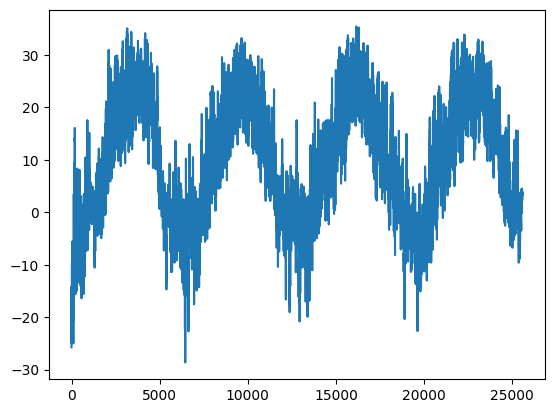

In [17]:
import matplotlib.pyplot as plt


plt.plot(the_df["t2m_nysm_1"])

Isolate one NYSM station and drop unnecessary columns 

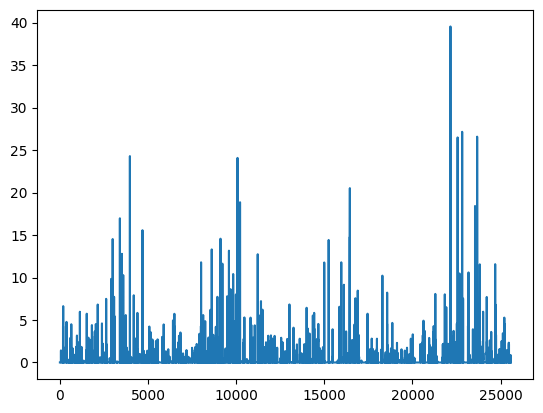

In [18]:
plt.plot(the_df["new_tp_nysm_1"])

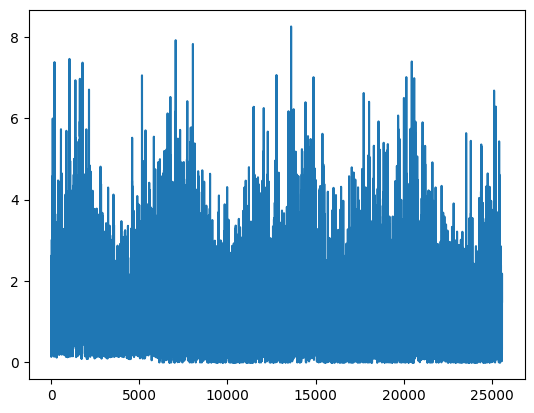

In [19]:
plt.plot(the_df["u_total_nysm_1"])

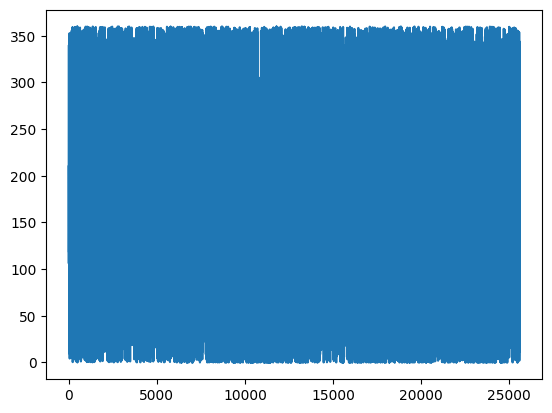

In [20]:
plt.plot(the_df["u_dir_nysm_1"])

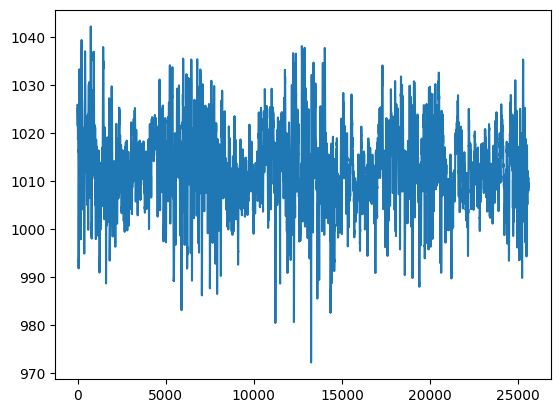

In [21]:
plt.plot(the_df["mslma_nysm_1"])

Create your target variable, and create a target variable column. The newly created target column won’t have values in the final 12 rows, so we’ll drop those

In [22]:
target_sensor = "t2m_nysm_1"
features = list(the_df.columns.difference([target_sensor]))

forecast_lead = 12
target = f"{target_sensor}_lead_{forecast_lead}"

the_df[target] = the_df[target_sensor].shift(-forecast_lead)
the_df = the_df.iloc[:-forecast_lead]

In [23]:
the_df

t2m_HRRR_1  d2m_HRRR_1  u_total_HRRR_1  u_dir_HRRR_1  latitude_1  \
0      -26.027145  -28.905670        0.644868    187.528809   43.110052   
1      -21.798660  -25.074158        1.103367    155.350861   43.110052   
2      -19.001190  -22.717117        0.666412    145.490784   43.110052   
3      -17.341324  -21.778854        0.146325    117.390900   43.110052   
4      -16.004486  -21.128281        0.255038     85.514633   43.110052   
...           ...         ...             ...           ...         ...   
25562    3.065582    2.681366        0.793229    356.561768   43.110052   
25563    2.979492    2.760590        1.229656    304.769653   43.110052   
25564    2.876984    2.684204        1.116857     31.449684   43.110052   
25565    2.798462    2.607330        1.023953    309.393280   43.110052   
25566    2.865021    2.577362        2.456806    316.619690   43.110052   

       longitude_1  new_tp_HRRR_1  mslma_HRRR_1     orog_1  t2m_nysm_1  ...  \
0       -73.591823           0.00   1028.459961  40.151505  -25.742041  ...   
1       -73.591823           0.00   1029.729980  40.151505  -21.868660  ...   
2       -73.591823           0.00   1029.319946  40.151505  -19.732401  ...   
3       -73.591823           0.00   1028.380005  40.151505  -17.451130  ...   
4       -73.591823           0.00   1028.109985  40.151505  -15.916540  ...   
...            ...            ...           ...        ...         ...  ...   
25562   -73.591823           0.00   1013.859985  56.075890    2.281519  ...   
25563   -73.591823           0.48   1013.590027  56.075890    2.592484  ...   
25564   -73.591823           0.05   1013.059998  56.075890    2.574481  ...   
25565   -73.591823           0.00   1012.859985  56.075890    2.631667  ...   
25566   -73.591823           0.01   1012.489990  56.075890    2.515476  ...   

       new_tp_HRRR   mslma_HRRR        orog   t2m_nysm   d2m_nysm  \
0             0.00  1028.579956  123.089005 -22.250919 -27.442368   
1             0.00  1029.739990  123.089005 -19.860109 -26.330994   
2             0.00  1029.359985  123.089005 -18.014620 -25.542313   
3             0.00  1028.369995  123.089005 -16.514090 -24.623291   
4             0.00  1028.130005  123.089005 -14.927460 -23.760712   
...            ...          ...         ...        ...        ...   
25562         0.06  1013.760010  128.294647   2.625721   2.031281   
25563         0.44  1013.539978  128.294647   2.754891   2.441467   
25564         0.06  1012.909973  128.294647   2.545289   2.318542   
25565         0.00  1012.739990  128.294647   2.645174   2.360687   
25566         0.56  1012.539978  128.294647   2.372275   2.227814   

       u_total_nysm  u_dir_nysm  new_tp_nysm   mslma_nysm  t2m_nysm_1_lead_12  
0          2.854406  241.898193     0.000000  1013.429993          -23.948820  
1          2.980609  241.031998     0.000000  1013.505005          -24.013359  
2          4.187699  247.167999     0.000000  1012.857971          -24.094460  
3          3.436568  243.065002     0.000000  1012.085999          -24.056829  
4          4.266777  253.654800     0.000000  1011.153015          -25.021280  
...             ...         ...          ...          ...                 ...  
25562      0.310632   46.373871     0.000000   998.417175            3.899532  
25563      0.504635  316.776794     0.000000   998.312683            3.722372  
25564      0.619527  289.663208     0.000000   998.075928            3.513443  
25565      0.361268  324.822876     0.000000   998.058289            3.225442  
25566      0.629475  359.875397     0.429993   997.876282            3.391289  

[25567 rows x 46 columns]

Create and hold out a test set

In [24]:
test_start = 19563

df_train = the_df.iloc[:19563].copy()
df_test = the_df.iloc[19563:].copy()

print("Test set fraction:", len(df_test) / len(the_df))

Test set fraction: 0.2348339656588571


Standardize your features and target

In [25]:
target_mean = df_train[target].mean()
target_stdev = df_train[target].std()

for c in df_train.columns:
    mean = df_train[c].mean()
    stdev = df_train[c].std()

    df_train[c] = (df_train[c] - mean) / stdev
    df_test[c] = (df_test[c] - mean) / stdev

create a PyTorch Dataset class, which is simpler than you might think. This strategy lets us lean on PyTorch’s nice DataLoader class to keep the model training and evaluation code super clean.

Our custom Dataset just needs to specify what happens when somebody requests the i’th element of the dataset. In a tabular dataset, this would be the i’th row of the table, but here we need to retrieve a sequence of rows.

So, given i and the sequence_length, we return the block of data from i - sequence_length through row i. If i is at the beginning of the dataset, we pad by repeating the first row as many times as needed to make the output have sequence_length rows. The only trick is avoiding off-by-1 errors in the slicing and padding.

All the magic happens in the __getitem__ method in this snippet.

In [26]:
import torch
from torch.utils.data import Dataset


class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[target].values).float()
        self.X = torch.tensor(dataframe[features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i):
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start : (i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0 : (i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]

In [27]:
# Let’s look at a small example to build intuition about how it works. Namely, let’s grab the 27’th entry in the dataset with a sequence length of 4.

i = 27
sequence_length = 4

train_dataset = SequenceDataset(
    df_train, target=target, features=features, sequence_length=sequence_length
)

X, y = train_dataset[i]
print(X)

tensor([[-1.4960e+00, -1.4172e+00, -1.5603e+00, -1.7259e+00, -1.7429e+00,
         -1.7752e+00, -1.6142e-03, -5.4111e-04, -8.2540e-04,  0.0000e+00,
          8.1898e-04,  0.0000e+00,  8.2337e-01,  8.1668e-01,  8.6332e-01,
          6.2937e-01,  7.0738e-01,  6.7473e-01, -1.1761e-01, -1.3542e-01,
         -1.4472e-01, -1.6485e-01, -1.6540e-01, -1.5294e-01, -2.2914e-01,
         -2.2914e-01,  2.2915e-01, -1.3640e+00, -1.3828e+00, -1.4381e+00,
         -1.6941e+00, -1.6763e+00,  4.6284e-01,  1.0735e-02,  3.4897e-02,
         -9.7651e-02, -2.0015e-01, -4.0753e-01,  5.8216e-01,  5.0645e-01,
          7.2661e-01,  2.5710e-01,  8.0230e-01, -3.4398e-01],
        [-1.5534e+00, -1.5684e+00, -1.5813e+00, -1.7591e+00, -1.8215e+00,
         -1.7391e+00, -1.6142e-03, -5.4111e-04, -8.2540e-04,  0.0000e+00,
          8.1898e-04,  0.0000e+00,  7.7376e-01,  7.6739e-01,  8.1489e-01,
          5.9876e-01,  6.8067e-01,  6.3252e-01, -1.5124e-01, -1.3542e-01,
         -1.5868e-01, -1.6485e-01, -1.6540e-01, -1

The next step is to set the dataset in a PyTorch DataLoader, which will draw minibatches of data for us. Let’s try a small batch size of 3, to illustrate.

In [28]:
from torch.utils.data import DataLoader

torch.manual_seed(99)

train_loader = DataLoader(train_dataset, batch_size=3, shuffle=True)

X, y = next(iter(train_loader))
print(X.shape)
print(X)

torch.Size([3, 4, 44])
tensor([[[-4.5173e-01, -3.6538e-01, -3.7778e-01, -3.9085e-01, -4.0657e-01,
          -3.8782e-01, -1.6142e-03, -5.4111e-04, -8.2540e-04,  0.0000e+00,
           8.1898e-04,  0.0000e+00, -1.6650e-01, -1.8140e-01, -1.5718e-01,
          -9.7343e-02, -1.0415e-01, -1.2303e-01, -1.5124e-01, -1.4805e-01,
          -1.5868e-01, -1.6485e-01, -1.6540e-01, -1.5294e-01,  4.3639e+00,
           4.3638e+00, -4.3638e+00, -5.6540e-01, -5.2912e-01, -5.6440e-01,
          -3.5792e-01, -3.7285e-01,  6.5365e-01,  1.3722e-01,  4.8333e-01,
           9.7770e-01,  4.7207e-01,  8.7692e-01,  1.1726e+00,  4.0436e-01,
           9.2074e-01,  3.0368e-01, -3.5751e-01,  1.3884e+00],
         [-4.6208e-01, -4.2549e-01, -4.2575e-01, -4.8958e-01, -4.8100e-01,
          -4.8763e-01, -1.6142e-03, -5.4111e-04, -8.2540e-04,  0.0000e+00,
           8.1898e-04,  0.0000e+00, -9.3890e-02, -1.1406e-01, -7.7285e-02,
          -4.6735e-02, -8.2112e-02, -8.1318e-02, -1.5124e-01, -1.4805e-01,
          -1.5

with a sequence of 48 time steps. For training, we’ll shuffle the data (the rows within each data sequence are not shuffled, only the order in which we draw the blocks). For the test set, shuffling isn’t necessary.

In [29]:
torch.manual_seed(101)

batch_size = 4
sequence_length = 12

train_dataset = SequenceDataset(
    df_train, target=target, features=features, sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test, target=target, features=features, sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([4, 12, 44])
Target shape: torch.Size([4])


Most importantly, we have to keep track of which dimension represents the batch in our input tensors. As we just saw, our data loaders use the first dimension for this, but the PyTorch LSTM layer’s default is to use the second dimension instead. So we set batch_first=True to make the dimensions line up, but confusingly, this doesn’t apply to the hidden and cell state tensors. In the forward method, we initialize h0 and c0 with batch size as the second dimension.

We’ll hard code a single layer just to keep things simple.

The output layer of the model is linear with a single output unit because we’re doing regression. This is one of only two lines of code that would need to change for a classification task.

In [30]:
from torch import nn


class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 3

        self.lstm = nn.LSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers,
        )
        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(
            self.num_layers, batch_size, self.hidden_units
        ).requires_grad_()
        c0 = torch.zeros(
            self.num_layers, batch_size, self.hidden_units
        ).requires_grad_()

        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(
            hn[0]
        ).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out

In [31]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [32]:
learning_rate = 5e-5
num_hidden_units = 16

model = ShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

## Training

In [33]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # loss
    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")
    return avg_loss


def test_model(data_loader, model, loss_function):
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    # loss
    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")

    return avg_loss

In [34]:
batch_size = 100
sequence_length = 12
learning_rate = 0.001
num_hidden_units = 30

experiment = Experiment(
    api_key="leAiWyR5Ck7tkdiHIT7n6QWNa",
    project_name="general",
    workspace="shmaronshmevans",
)
torch.manual_seed(101)

batch_size = batch_size
sequence_length = sequence_length

train_dataset = SequenceDataset(
    df_train, target=target, features=features, sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test, target=target, features=features, sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

learning_rate = learning_rate
num_hidden_units = num_hidden_units

model = ShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
early_stopper = EarlyStopper(patience=5, min_delta=0)


print("Untrained test\n--------")
test_model(test_loader, model, loss_function)
print()

for ix_epoch in range(50):
    print(f"Epoch {ix_epoch}\n---------")
    train_loss = train_model(train_loader, model, loss_function, optimizer=optimizer)
    val_loss = test_model(test_loader, model, loss_function)
    print()
    if early_stopper.early_stop(val_loss):
        break

# Report multiple hyperparameters using a dictionary:
hyper_params = {
    "learning_rate": learning_rate,
    "steps": sequence_length,
    "batch_size": batch_size,
}
experiment.log_parameters(hyper_params)

# Seamlessly log your Pytorch model
log_model(experiment, model, model_name="TheModel")
experiment.end()

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/shmaronshmevans/general/accdf3be93d347e7bdd634d9855a4888



Features shape: torch.Size([100, 12, 44])
Target shape: torch.Size([100])
Untrained test
--------
Test loss: 0.862204273582482

Epoch 0
---------
Train loss: 0.19157025826220608
Test loss: 0.5763737020143842

Epoch 1
---------
Train loss: 0.09472386329909976
Test loss: 0.42337391704137695

Epoch 2
---------
Train loss: 0.08381365201607043
Test loss: 0.3939058233327309

Epoch 3
---------
Train loss: 0.07809627280399507
Test loss: 0.38370422217002537

Epoch 4
---------
Train loss: 0.07341581970757367
Test loss: 0.3953228872231223

Epoch 5
---------
Train loss: 0.06965821764755006
Test loss: 0.4122585950449842

Epoch 6
---------
Train loss: 0.06689761624652513
Test loss: 0.3417559797096936

Epoch 7
---------
Train loss: 0.06402422041081045
Test loss: 0.2926161020505624

Epoch 8
---------
Train loss: 0.06080271851043312
Test loss: 0.29406653338524164

Epoch 9
---------
Train loss: 0.058788459006772965
Test loss: 0.26120229208933526

Epoch 10
---------
Train loss: 0.056645621697665474
Test 

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/shmaronshmevans/general/accdf3be93d347e7bdd634d9855a4888
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [471] : (0.026630768552422523, 1.1315194368362427)
COMET INFO:   Parameters:
COMET INFO:     batch_size    : 100
COMET INFO:     learning_rate : 0.001
COMET INFO:     steps         : 12
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     git metadata                 : 1
COMET INFO:  

## Evalutation

Evaluating the model is straightforward. First, let’s define a variant of the test function that actually returns the predictions. We also need a new DataLoader for the training set that isn’t shuffled, we can visualize the training and test set predictions chronologically. Lastly, it’s nice to un-standardize the predictions so they’re back in their original units.

In [35]:
def predict(data_loader, model):
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)

    return output


train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col = "Model forecast"
df_train[ystar_col] = predict(train_eval_loader, model).numpy()
df_test[ystar_col] = predict(test_loader, model).numpy()

df_out = pd.concat((df_train, df_test))[[target, ystar_col]]

for c in df_out.columns:
    df_out[c] = df_out[c] * target_stdev + target_mean

print(df_out)

       t2m_nysm_1_lead_12  Model forecast
0              -23.948822      -24.094582
1              -24.013359      -23.342495
2              -24.094460      -22.609306
3              -24.056831      -20.582531
4              -25.021282      -19.577953
...                   ...             ...
25562            3.899532        0.422028
25563            3.722372        0.485361
25564            3.513443        0.990995
25565            3.225441        1.177804
25566            3.391289        1.992466

[25567 rows x 2 columns]


In [36]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

pio.templates.default = "plotly_white"
plot_template = dict(
    layout=go.Layout(
        {"font_size": 18, "xaxis_title_font_size": 24, "yaxis_title_font_size": 24}
    )
)

fig = px.line(df_out, labels=dict(created_at="Date", value="T2M [Celsius]"))
fig.add_vline(x=test_start, line_width=4, line_dash="dash")
fig.add_annotation(
    xref="paper", x=0.75, yref="paper", y=0.8, text="Test set start", showarrow=False
)
fig.update_layout(
    template=plot_template, legend=dict(orientation="h", y=1.02, title_text="")
)
fig.show()